# INTRODUCTION TO MACHINE LEARNING PROJECT

## Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt

#np.random.seed(270320)

# NOTES
# TODO make doxygen-like comments ?
# TODO confirm the experimental results with theoretical results
# TODO weighted knn, weighting the closest points 
# TODO calculate variance and std to know the right number of folds
# TODO do PCA function from scratch
# TODO for the best k, redo cross val to tune the best distance metric
# TODO mixing/averaging distances metrics and compare the scores
# TODO modify assert into raise ValueError for user input verif
# TODO return just the conf matrix and then implement functions that calculate the other metrics based on it
# TODO start LATEX
# TODO rajouter std dans les comparaisons
# TODO see if condition over k for CNN and comment in knn function
# TODO calculate the bound of R(h)<=R^(h)+Variance, but need to find the complexity measure of knn
# TODO tune K as to maximize the F-measure, see part on imbalanced dataset in lecture on KNN
# TODO test knn on reduced dimensions and compare results, like do PCA then knn, see if it affected here by the curse of dim.
# TODO plot the bias/variance tradeoff by showing that small value of k gives a low bias but high variance and inversely symmetrical


## Loading Data

In [13]:
from sklearn.decomposition import PCA

# Assuming features is a NumPy array
def plot_pca(x, y, train_point_size=10):
    # Applying PCA to reduce to 2 dimensions for visualization
    pca = PCA(n_components=2)
    x_train_pca = pca.fit_transform(x)
    
    plt.figure(figsize=(8, 6), dpi=60)
    scatter = plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y, cmap='viridis', marker='o', s=train_point_size)

    plt.colorbar(scatter)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

    
def load_data(dataset_file):
    return np.loadtxt(dataset_file, delimiter=',')

data = load_data('./waveform.data')

# Splitting the features and the labels into two different arrays
features = np.array(data[:,:data.shape[1]-1])

# Normalization of the features such that each feature has a mean = 0 and std = 1
def normalization(feat_to_norm) :
    new = np.empty(shape=feat_to_norm.shape)
    for i in range(feat_to_norm.shape[1]) :
        mean = np.mean(feat_to_norm[:,i])
        std = np.std(feat_to_norm[:,i])
        new[:,i] = (feat_to_norm[:,i] - mean) / std
    return new

#features = normalization(feat_to_norm=features)

labels = np.array(data[:,data.shape[1]-1:])

###  Creating the dataset in python

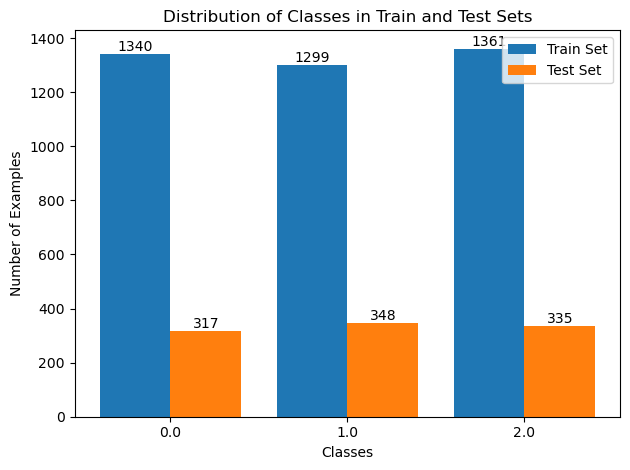

In [14]:
def train_test_split(features, labels, train_ratio):
    assert features.shape[0] == labels.shape[0], "Error : dimensions of features and labels should be the same"

    # Randomly shuffling the dataset's indices to pick randomly the training and test examples
    shuffled_indices = np.arange(features.shape[0])
    np.random.shuffle(shuffled_indices)
    train_size = int(len(shuffled_indices) * train_ratio)
    train_indices = shuffled_indices[:train_size]
    test_indices = shuffled_indices[train_size:]

    x_set = features[train_indices]
    x_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]

    assert x_set.shape[0] == y_train.shape[0], "Error : creation of training set went wrong."
    assert x_test.shape[0] == y_test.shape[0], "Error : creation of testing set went wrong."

    return x_set, x_test, y_train, y_test

#Creation of the training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(features, labels, 0.8)

#Plotting the distribution of the training and test set
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)
fig, ax = plt.subplots()
bar_width = 0.4
train_positions = np.arange(len(train_classes))
test_positions = train_positions + bar_width
bar1 = ax.bar(train_positions, train_counts, bar_width, label='Train Set')
bar2 = ax.bar(test_positions, test_counts, bar_width, label='Test Set')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Examples')
ax.set_title('Distribution of Classes in Train and Test Sets')
ax.set_xticks(train_positions + bar_width / 2)
ax.set_xticklabels(train_classes)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
ax.legend()
plt.tight_layout()
plt.show()


### Various functions

In [15]:
# Returns an array with the euclidian distances from x to every x' in x_array
def euclidian_dist_array(x, x_array):
    return np.linalg.norm(x_array - x, axis=1)

# Returns a matrix with the distance for each point of matrixA with respect to matrixB
def distance_matrix(matrixA, matrixB):
    #return scipy.spatial.distance_matrix(matrixA, matrixB, p=2)
    res = np.zeros((matrixA.shape[0], matrixB.shape[0]))
    for i in range(matrixA.shape[0]):
        distance = euclidian_dist_array(matrixA[i], matrixB)
        res[i] = distance
    return res

def accuracy(nb_true, nb_total):
    return (nb_true * 100) / nb_total

## KNN Algorithm

In [16]:
# Compute and returns the majority class from the features amongst the k nearest neighbors of a new input
# OR the distances needs to be precomputed and passed in distance_mat
# labels is composed of the corresponding labels for each value of the distance_mat

def knn(labels, k, distance_tab=None, new_input=None, features_set=None):
    # Getting the precomputed distances from the distance_tab if it is passed in the arguments
    if distance_tab is not None:
        if (len(labels) != len(distance_tab)):
            raise ValueError("Error : The number of labels doesn't correspond to the number of distances.")
        dist_array = distance_tab
    # Else compute the distance tab from new_input to the set
    else :
        if new_input is not None and features_set is not None :
            if (len(labels) != features_set.shape[0]):
                raise ValueError("Error : number of labels not corresponding to the number of samples of features_set")
            dist_array = euclidian_dist_array(new_input, features_set)

    # Getting the k nearest distances
    if len(dist_array) > k:
        k_nearest_indices = np.argpartition(dist_array, k)[:k]
    else :  #for CNN when there is only one element in features_set, maybe find a way to avoid this
        k_nearest_indices = np.argsort(dist_array)

    # Get the labels of the k nearest neighbors
    classes = labels[k_nearest_indices].ravel()

    # Count the number of occurences of each class Yj among the k nearest neighbors
    counts = np.bincount(classes[:k].astype(int))

    # Return the class with the highest count
    majority_class = np.argmax(counts)

    return majority_class


### Metrics calculation : accuracy, confusion matrix, etc...

In [17]:
def metrics_calculation(cm):
    total_pred = np.sum(cm)
    TP = [] #True Positives for each class
    TN = [] #True Negatives for each class
    FP = [] #False Positives for each class
    FN = [] #False Negatives for each class
    for i in range(cm.shape[0]) : 
        TP.append(cm[i,i])
        FP.append(np.sum(cm[:, i]) - cm[i, i])
        FN.append(np.sum(cm[i, :]) - cm[i, i])
        TN.append(total_pred - (FP[i] + FN[i] + TP[i]))
    
    accuracy = np.sum(TP) / total_pred
    error = 1 - accuracy
    precision = np.sum(TP) / np.sum(TP+FP)
    recall = np.sum(TP) / np.sum(TP+FN)
    beta = 1
    f_measure = ((1+(beta**2)) * precision * recall) / (((beta**2) * precision) + recall)

    return accuracy, error, f_measure

In [18]:
# Returns the accuracy, confusion matrix of the prediction of the test set amongst the train set
# distance_mat : precomputed distances between train set and test set

def prediction_metrics(y_set_train, y_set_test, k, distance_mat=None, x_set_train=None, x_set_test=None):
    len_y_set_test = len(y_set_test)
    classes = np.unique(y_set_test)
    nb_classes = len(classes)
    confusion_matrix = np.zeros((nb_classes, nb_classes))

    # Using the precomputed distance matrix if provided, else using the x_set_train and x_set_test and computing the distances in the knn function
    knn_function = lambda i : knn(y_set_train, k, distance_mat[i]) if distance_mat is not None else knn(y_set_train, k, new_input=x_set_test[i], features_set=x_set_train)

    # Predict the class for each point of the set test amongst the set train
    for i in range(len_y_set_test) :
        y_pred = knn_function(i)
        y_actual = y_set_test[i, 0]

        # Filling the confusion matrix
        index_pred = np.where(classes == y_pred)[0][0]
        index_actual = np.where(classes == y_actual)[0][0]
        confusion_matrix[index_actual, index_pred] += 1

    accuracy, error, f_measure = metrics_calculation(cm = confusion_matrix)
    return accuracy, error, f_measure, confusion_matrix


# Tuning k by cross-validation

### Creating the k folds

In [19]:
# Splitting the training set into x_subsets for cross-validation
def k_folds(x_training_set, y_training_set, nb_folds):
    if nb_folds > x_training_set.shape[0]:
        raise ValueError("Error : number of folds exceeding the number of samples in the dataset.")
    # Shuffling the sets to get random folds
    indices = np.arange(x_training_set.shape[0])
    np.random.shuffle(indices)
    x_shuffled = x_training_set[indices]
    y_shuffled = y_training_set[indices]
    
    # Split the shuffled data into folds
    x = np.array_split(x_shuffled, nb_folds)
    y = np.array_split(y_shuffled, nb_folds)

    assert len(x) == len(y), "Error creating the subsets for cross-validation"
    return x, y

nb_folds = 5
x_subsets, y_subsets = k_folds(x_train, y_train, nb_folds)


### Pre-computing the distances of the k folds between them

In [20]:
# Returns a list of distances matrix of each fold of x_folds against the remaining folds
def list_distance_matrix(nb_folds, x_folds):
    # Precompute the distances between each fold and the k-1 other folds to accelerate computation
    list_dist_mat = []
    for i in range(nb_folds) : 
        x_tmp_training = np.concatenate([x_folds[j] for j in range(nb_folds) if j != i], axis=0)
        x_val_fold = x_folds[i]
        dist_mat = distance_matrix(x_val_fold, x_tmp_training)
        list_dist_mat.append(dist_mat)
    return list_dist_mat

list_dist_mat = list_distance_matrix(nb_folds=nb_folds, x_folds=x_subsets)


### Cross-validation algorithm

In [21]:
# Returns the metrics for a given k using cross-validation
def cross_validation(k, y_train_folds, nb_folds, list_dist_mat):
    fold_accuracies = []
    fold_errors = []
    fold_f_measures = []
    fold_confusion_matrices = []

    # Computing the metrics for each fold taken once(as a validation fold) over the k-1 training folds
    for i in range(nb_folds):
        # Remove the validation set from the training set
        y_tmp_training = np.concatenate([y_train_folds[j] for j in range(nb_folds) if j != i], axis=0)

        # Take the remaining fold as the validation fold
        y_val_fold = y_train_folds[i]
        
        fold_accuracy, fold_error, fold_f_measure, fold_cm = (prediction_metrics(distance_mat=list_dist_mat[i],
                                                     y_set_train=y_tmp_training, 
                                                     y_set_test=y_val_fold, 
                                                     k=k))
        fold_accuracies.append(fold_accuracy)
        fold_errors.append(fold_error)
        fold_f_measures.append(fold_f_measure)
        fold_confusion_matrices.append(fold_cm)

    print("Validation folds accuracies :"+str(fold_accuracies))
    print("Errors : "+str(fold_errors))
    print("F_measures : "+str(fold_f_measures))
    
    # Returning the mean of the metrics
    mean_accuracy = np.mean(fold_accuracies)
    mean_error = np.mean(fold_errors)
    mean_f_measure = np.mean(fold_f_measures)
    mean_confusion_matrix = np.mean(fold_confusion_matrices, axis=0)
    return mean_accuracy, mean_error, mean_f_measure, mean_confusion_matrix

### Finding the best k using cross-validation

In [22]:
# Returns the best k using cross-validation
def tuning_k(nb_folds, y_folds, k_range, list_dist_mat):
    list_accuracies = []
    list_errors = []
    list_f_measures = []
    list_confusion_matrices = []

    # Iterate over the whole k range
    for k in k_range : 
        print("k = "+str(k))
        # Get the mean metrics for this k over the entire folds using cross-validation
        mean_acc, mean_error, mean_f_measure, mean_cm = cross_validation(k, y_folds, nb_folds, list_dist_mat)
        list_accuracies.append(mean_acc)  
        list_errors.append(mean_error)
        list_f_measures.append(mean_f_measure)
        list_confusion_matrices.append(mean_cm)
        print("Mean accuracy = "+str(mean_acc))
        print("Mean error : "+str(mean_error))
        print("Mean f_measure : "+str(mean_f_measure))
        print("Mean confusion Matrix : \n"+str(mean_cm))

    max_accuracy = max(list_accuracies)
    best_k = k_range[list_accuracies.index(max_accuracy)] 

    # Returning the best k found, the mean accuracies for each k over the folds, and the mean CM for each k
    return best_k, list_accuracies, list_errors, list_f_measures, list_confusion_matrices

k_max = int(x_train.shape[0] - (x_train.shape[0] / nb_folds))
k_range = range(1, 100)
best_k, accuracies, errors, f_measures, confusion_matrices = tuning_k(nb_folds=nb_folds, y_folds=y_subsets, k_range=k_range, list_dist_mat=list_dist_mat)
max_accuracy = max(accuracies)


k = 1
Validation folds accuracies :[0.775, 0.7875, 0.77375, 0.79875, 0.8025]
Errors : [0.22499999999999998, 0.21250000000000002, 0.22624999999999995, 0.20125000000000004, 0.1975]
F_measures : [0.775, 0.7875, 0.77375, 0.79875, 0.8025]
Mean accuracy = 0.7875
Mean error : 0.2125
Mean f_measure : 0.7875
Mean confusion Matrix : 
[[200.8  32.6  34.6]
 [ 29.2 210.8  19.8]
 [ 33.4  20.4 218.4]]
k = 2
Validation folds accuracies :[0.77875, 0.77125, 0.75375, 0.80875, 0.7675]
Errors : [0.22124999999999995, 0.22875, 0.24624999999999997, 0.19125000000000003, 0.23250000000000004]
F_measures : [0.77875, 0.77125, 0.75375, 0.8087499999999999, 0.7675]
Mean accuracy = 0.776
Mean error : 0.22400000000000003
Mean f_measure : 0.776
Mean confusion Matrix : 
[[234.   15.4  18.6]
 [ 49.4 201.8   8.6]
 [ 51.6  35.6 185. ]]
k = 3
Validation folds accuracies :[0.79875, 0.80875, 0.82, 0.81375, 0.7975]
Errors : [0.20125000000000004, 0.19125000000000003, 0.18000000000000005, 0.18625000000000003, 0.2025]
F_measures :

### Plotting of the accuracies with respect to k

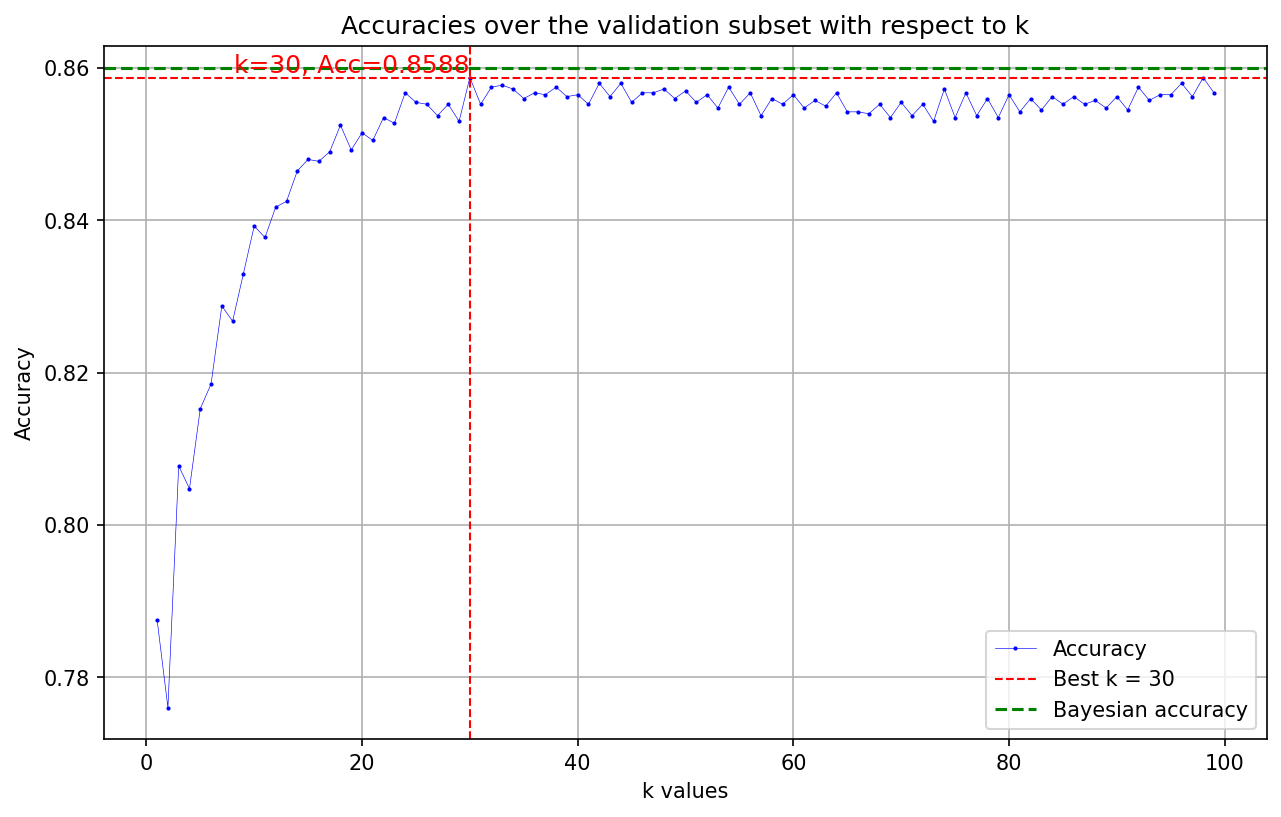

In [23]:
def plot_accuracies(tab_accuracies, y_accuracy, x_k, title):
    plt.figure(figsize=(10, 6), dpi=150) 
    plt.plot(k_range, tab_accuracies, label='Accuracy', marker='o', color='b',markersize=1,linestyle='-', linewidth=.3)
    plt.axvline(x=x_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {best_k}')
    plt.axhline(y=y_accuracy, color='r', linestyle='--', linewidth=1)
    plt.axhline(y=.86, color='g', linestyle='--', label=f'Bayesian accuracy')
    plt.text(x_k, y_accuracy, f'k={x_k}, Acc={y_accuracy:.4f}', 
            horizontalalignment='right', verticalalignment='bottom', 
            color='red', fontsize=12)
    plt.xlabel('k values')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(0, max(k_range)+2, 20)) 
    #plt.yticks(np.arange(30, 90, 10)) 
    #plt.axhline(y=(1/3*100), color='orange', linestyle='--', label=f'Random Guessing')
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.show()

plot_accuracies(accuracies, max_accuracy, best_k, "Accuracies over the validation subset with respect to k")


In [24]:
# PCA comparisons
""" plt.figure(figsize=(10, 6), dpi=200)
for p in range(2, 22):
    pca = PCA(n_components=p)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.fit_transform(x_test)

    x_subsets_pca, y_subsets_pca = k_folds(x_train_pca, y_train, nb_folds)
    list_dist_mat_pca = list_distance_matrix(nb_folds=nb_folds, x_folds=x_subsets_pca)

    best_k_pca, accuracies_pca, confusion_matrices_pca = tuning_k(nb_folds=nb_folds, y_folds=y_subsets_pca, k_range=k_range, list_dist_mat=list_dist_mat_pca)
    max_accuracy_pca = max(accuracies_pca)

    plt.plot(k_range, accuracies_pca, label=f"p={p} (max acc={max_accuracy_pca:.2f}, best k={best_k_pca})")

plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracies over the validation subset with respect to k for different PCA components")
plt.legend(loc="best")
plt.grid(True)
plt.show() """

' plt.figure(figsize=(10, 6), dpi=200)\nfor p in range(2, 22):\n    pca = PCA(n_components=p)\n    x_train_pca = pca.fit_transform(x_train)\n    x_test_pca = pca.fit_transform(x_test)\n\n    x_subsets_pca, y_subsets_pca = k_folds(x_train_pca, y_train, nb_folds)\n    list_dist_mat_pca = list_distance_matrix(nb_folds=nb_folds, x_folds=x_subsets_pca)\n\n    best_k_pca, accuracies_pca, confusion_matrices_pca = tuning_k(nb_folds=nb_folds, y_folds=y_subsets_pca, k_range=k_range, list_dist_mat=list_dist_mat_pca)\n    max_accuracy_pca = max(accuracies_pca)\n\n    plt.plot(k_range, accuracies_pca, label=f"p={p} (max acc={max_accuracy_pca:.2f}, best k={best_k_pca})")\n\nplt.xlabel("k")\nplt.ylabel("Accuracy")\nplt.title("Accuracies over the validation subset with respect to k for different PCA components")\nplt.legend(loc="best")\nplt.grid(True)\nplt.show() '

### Confusion matrix of the best k

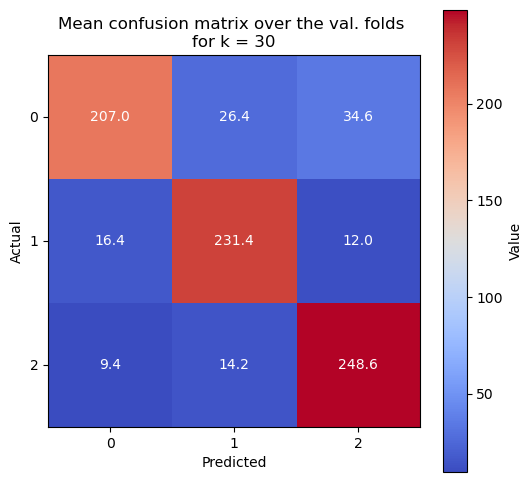

In [25]:
def plot_confusion_matrix(matrix, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, cmap='coolwarm')
    plt.colorbar(label='Value')
    for (i, j), value in np.ndenumerate(matrix):
        plt.text(j, i, f'{value}', ha='center', va='center', color='white')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.xticks(np.arange(matrix.shape[1]), ['0', '1', '2'])
    plt.yticks(np.arange(matrix.shape[0]), ['0', '1', '2'])
    plt.show()

confusion_mat_best_k = confusion_matrices[accuracies.index(max_accuracy)]
plot_confusion_matrix(confusion_mat_best_k,"Mean confusion matrix over the val. folds \nfor k = "+str(best_k))

### Prediction on the test set using the best k found

Accuracy : 0.848


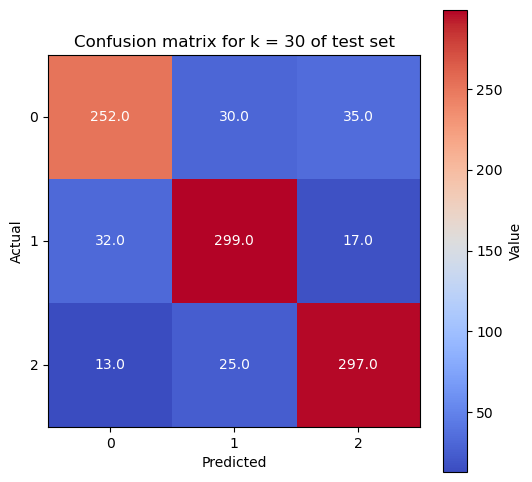

In [26]:
test_acc, test_error, test_f_measure, test_cm = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=best_k, x_set_train=x_train, x_set_test=x_test)
print("Accuracy : "+str(test_acc))
plot_confusion_matrix(test_cm,"Confusion matrix for k = "+str(best_k)+" of test set")

test_accuracies = []
test_errors = []
test_f_measures = []
dist_mat_test_train = distance_matrix(x_test, x_train)
for k in k_range : 
    k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=k, distance_mat=dist_mat_test_train)
    test_accuracies.append(k_acc)
    test_errors.append(k_error)
    test_f_measures.append(k_f_measure)


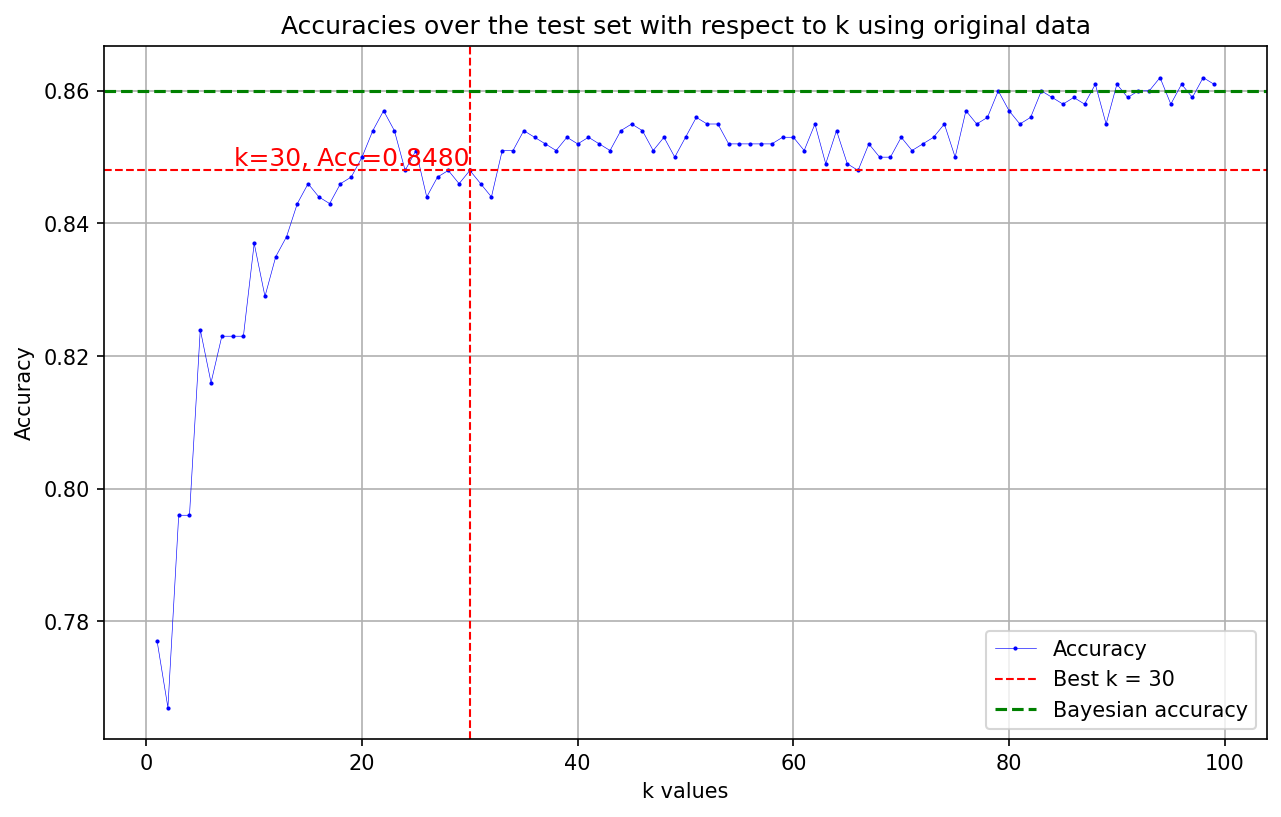

In [27]:
plot_accuracies(test_accuracies, test_acc, best_k,"Accuracies over the test set with respect to k using original data")

# Reducing complexity

### Data Reduction : Step 1

Initial data :


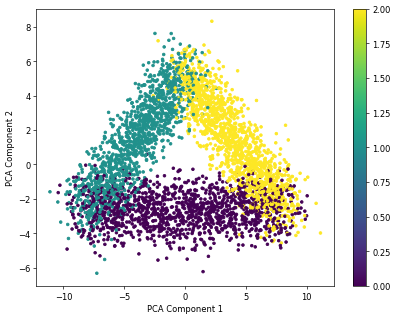

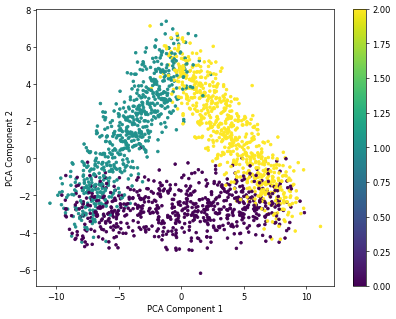

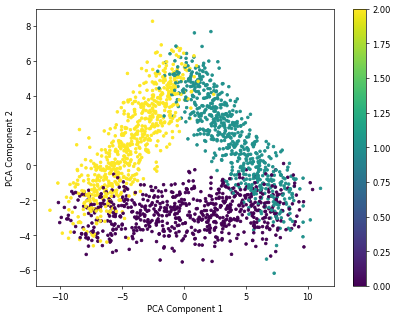

----------------
[3, 6, 12, 21, 22, 24, 26, 31, 45, 47, 51, 53, 56, 62, 66, 77, 79, 85, 94, 95, 102, 106, 109, 112, 119, 121, 123, 127, 139, 144, 147, 156, 157, 159, 163, 166, 168, 169, 172, 175, 183, 188, 189, 193, 198, 199, 205, 207, 211, 212, 215, 223, 224, 229, 239, 243, 244, 245, 246, 250, 261, 262, 264, 266, 268, 269, 270, 280, 282, 289, 290, 291, 292, 298, 310, 311, 313, 316, 320, 322, 324, 325, 326, 336, 337, 342, 353, 354, 357, 361, 366, 370, 374, 379, 389, 391, 393, 399, 409, 410, 414, 419, 420, 424, 433, 436, 442, 446, 447, 448, 459, 469, 471, 472, 473, 477, 483, 486, 497, 498, 500, 505, 506, 510, 511, 513, 522, 528, 530, 531, 532, 534, 535, 543, 544, 549, 555, 556, 568, 572, 573, 585, 590, 591, 594, 597, 598, 599, 606, 616, 620, 624, 628, 631, 636, 643, 644, 646, 652, 657, 660, 669, 672, 673, 690, 693, 697, 698, 699, 704, 708, 709, 711, 719, 720, 721, 722, 725, 727, 737, 746, 752, 758, 759, 761, 764, 766, 767, 772, 779, 784, 785, 791, 792, 794, 796, 798, 800, 804, 806, 807,

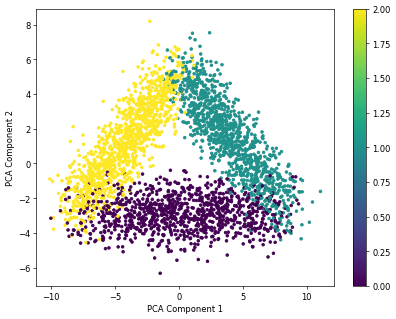

In [28]:
def remove_outliers_and_bayes_region(x_set, y_set) :
    n_k = 1
    # Splittiing randomly S into S1 and S2
    x_cleaned, y_cleaned = k_folds(x_training_set=x_set, y_training_set=y_set, nb_folds=2)
    plot_pca(x=x_cleaned[0], y=y_cleaned[0])
    plot_pca(x=x_cleaned[1], y=y_cleaned[1])

    list_indices_S1 = []
    list_indices_S2 = []

    while(True):
        # Classifying S1 with S2 using the 1-NN rule
        for i in range (len(x_cleaned[0])):
            y_pred = knn(labels = y_cleaned[1], k=n_k, new_input = x_cleaned[0][i], features_set = x_cleaned[1])
            y_actual = y_cleaned[0][i]
            # Stocking the examples misclassified
            if (y_pred != y_actual):
                list_indices_S1.append(i)

        if len(list_indices_S1) > 0:
            x_cleaned[0] = np.delete(x_cleaned[0], list_indices_S1, axis=0)
            y_cleaned[0] = np.delete(y_cleaned[0], list_indices_S1, axis=0)

        # Classifying S2 with the new set S1 using the 1-NN rule
        for i in range(len(x_cleaned[1])):
            y_pred = knn(labels = y_cleaned[0], k=n_k, new_input = x_cleaned[1][i], features_set = x_cleaned[0])
            y_actual = y_cleaned[1][i]
            # Stocking the examples misclassified
            if (y_pred != y_actual):
                list_indices_S2.append(i)

        if len(list_indices_S2) > 0:
            x_cleaned[1] = np.delete(x_cleaned[1], list_indices_S2, axis=0)
            y_cleaned[1] = np.delete(y_cleaned[1], list_indices_S2, axis=0)

        print("----------------")
        print(list_indices_S1)
        print(list_indices_S2)

        # If there is nothing in list_indices of S1 and S2 it means that all examples have been correctly classified 
        if (len(list_indices_S1) == 0 and len(list_indices_S2) == 0):
            break

        list_indices_S1.clear()
        list_indices_S2.clear()

    new_x_cleaned = np.concatenate((x_cleaned[0], x_cleaned[1]))
    new_y_cleaned = np.concatenate((y_cleaned[0], y_cleaned[1]))
    return new_x_cleaned, new_y_cleaned

print("Initial data :")
plot_pca(x=x_train, y=y_train)

x_train_cleaned, y_train_cleaned = remove_outliers_and_bayes_region(x_set=x_train, y_set=y_train)

print("Cleaned data, outliers and examples of the bayesian region removed :")
print(x_train_cleaned.shape)
plot_pca(x=x_train_cleaned, y=y_train_cleaned)

### Prediction on the test set over the cleaned data

In [29]:
test_accuracies_cleaned = []
test_errors_cleaned = []
test_f_measures_cleaned = []
dist_mat_test_cleaned_train = distance_matrix(x_test, x_train_cleaned)
for k in k_range : 
    k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_train_cleaned, y_set_test=y_test, k=k,distance_mat=dist_mat_test_cleaned_train)
    test_accuracies_cleaned.append(k_acc)
    test_errors_cleaned.append(k_error)
    test_f_measures_cleaned.append(k_f_measure)

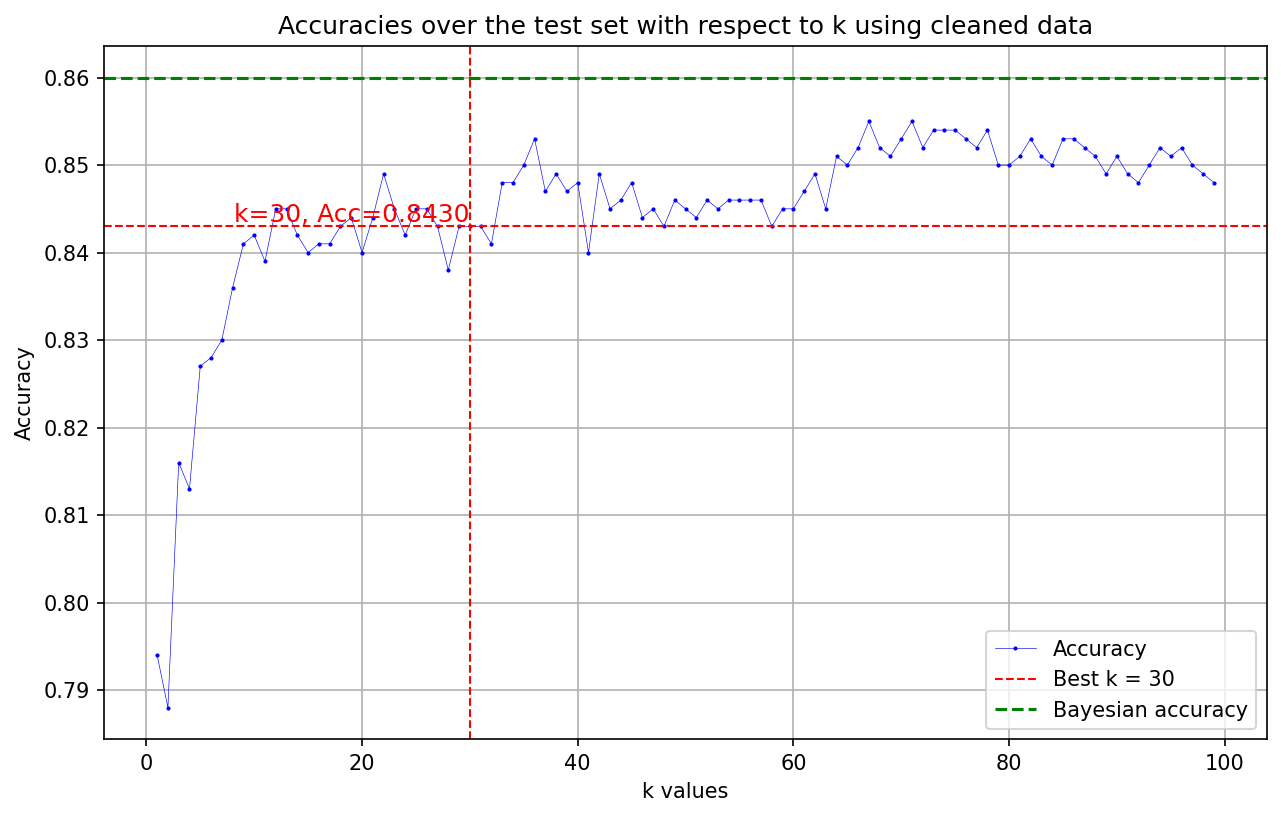

In [30]:
plot_accuracies(test_accuracies_cleaned, test_accuracies_cleaned[best_k], best_k,"Accuracies over the test set with respect to k using cleaned data")

### Data reduction : Step 2
### Condensed nearest neighbor rule

Data cleaned, before CNN :


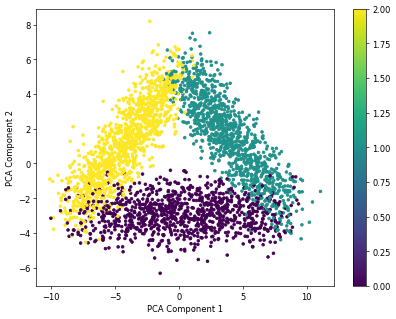

Number of samples in storage : 711
Data after CNN :
(711, 21)


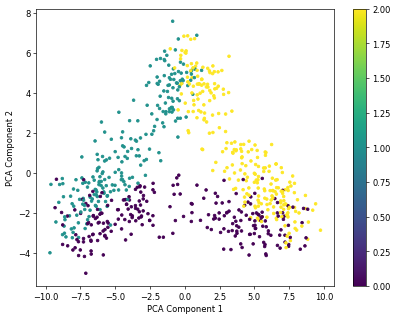

In [31]:
def condensed_nearest_neighbor(x_set, y_set):
    storage_x = np.empty((0, x_set.shape[1]))
    storage_y = np.array([])
    len_storage_prec = 0
    len_storage_actual = 0

    # Drawing randomly the first sample and putting it in Storage
    ith_example = np.random.randint(1, x_set.shape[0])
    storage_x = np.vstack([storage_x, x_set[ith_example]])
    storage_y = np.append(storage_y, y_set[ith_example])

    # While no stabilization of Storage 

    while(True):
        for i in range(len(x_set)):
            y_pred = knn(labels=storage_y, k=1, new_input=x_set[i], features_set=storage_x)
            y_actual = y_set[i]

            # If xi is incorrectly classified we add it to the storage, else we ignore it
            if (y_pred != y_actual) :
                storage_x = np.vstack([storage_x, x_set[i]])
                storage_y = np.append(storage_y, y_set[i])
            
        len_storage_actual = len(storage_x)

        if (len_storage_prec == len_storage_actual):
            break

        len_storage_prec = len_storage_actual

    print("Number of samples in storage : "+str(len_storage_actual))
    return storage_x, storage_y

print("Data cleaned, before CNN :")
plot_pca(x_train_cleaned, y_train_cleaned)
x_CNN, y_CNN = condensed_nearest_neighbor(x_train_cleaned, y_train_cleaned)
print("Data after CNN :")
print(x_CNN.shape)
plot_pca(x_CNN, y_CNN)


### Prediction on the test set over the condensed data

In [32]:
test_accuracies_CNN = []
test_errors_CNN = []
test_f_measures_CNN = []
dist_mat_test_CNN = distance_matrix(x_test, x_CNN)
for k in k_range : 
    k_acc, k_error, k_f_measure, k_cm = prediction_metrics(y_set_train=y_CNN, y_set_test=y_test, k=k, distance_mat=dist_mat_test_CNN)
    test_accuracies_CNN.append(k_acc)
    test_errors_CNN.append(k_error)
    test_f_measures_CNN.append(k_f_measure)


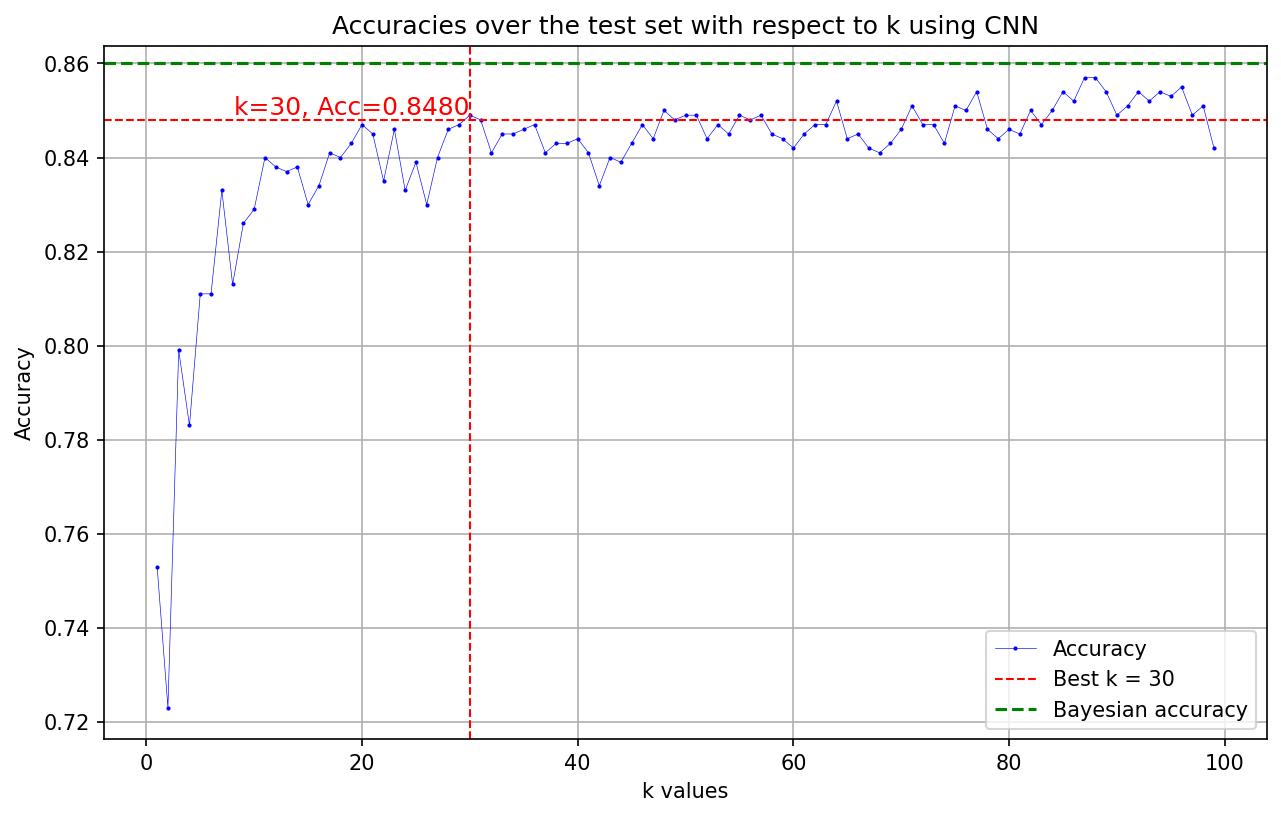

In [33]:
plot_accuracies(test_accuracies_CNN, test_accuracies_CNN[best_k], best_k,"Accuracies over the test set with respect to k using CNN")

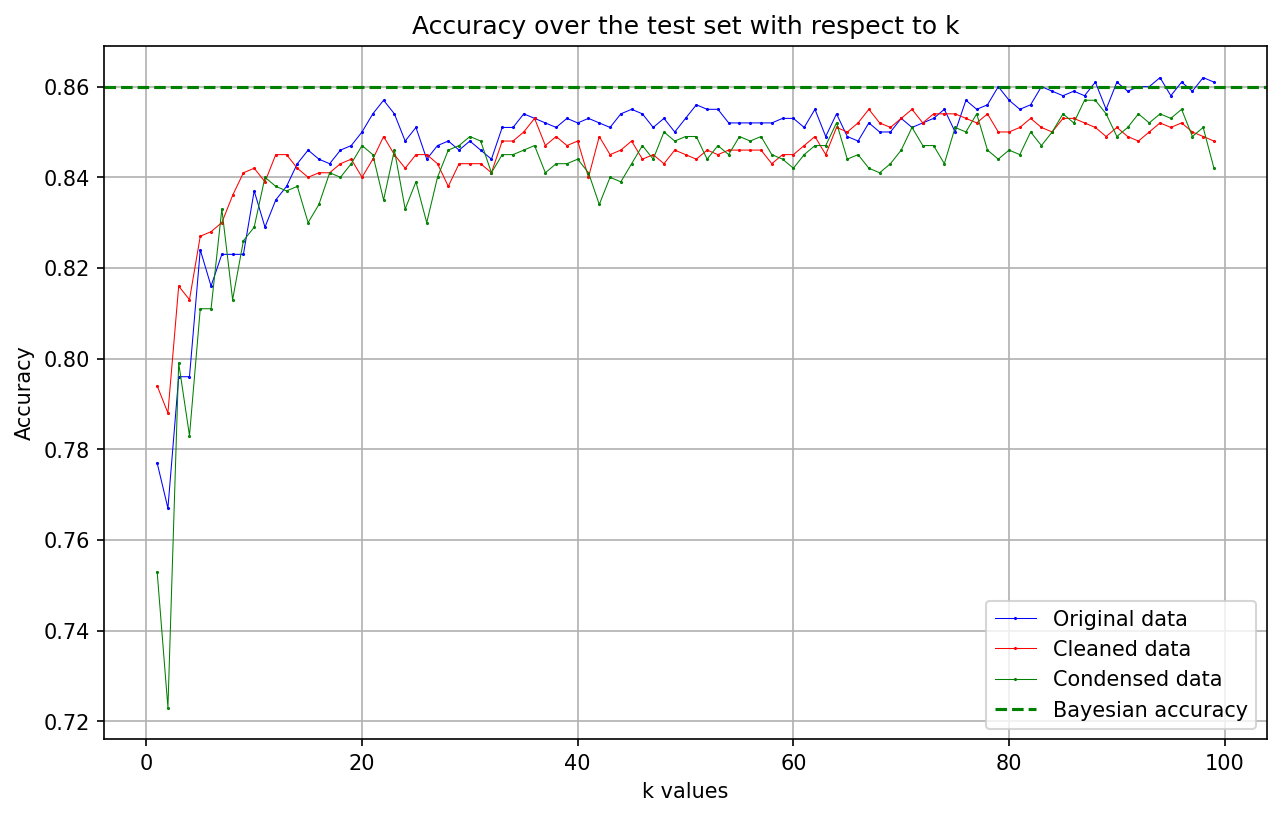

In [34]:
plt.figure(figsize=(10, 6), dpi=150) 
plt.plot(k_range, test_accuracies, label='Original data', marker='o', color='b',markersize=0.5,linestyle='-', linewidth=.5)
plt.plot(k_range, test_accuracies_cleaned, label='Cleaned data', marker='o', color='r', markersize=0.5, linestyle='-', linewidth=.5)
plt.plot(k_range, test_accuracies_CNN, label='Condensed data', marker='o', color='g', markersize=0.5, linestyle='-', linewidth=.5)
plt.axhline(y=.86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, max(k_range)+2, 20)) 
#plt.yticks(np.arange(30, 90, 10)) 
#plt.axhline(y=(1/3*100), color='orange', linestyle='--', label=f'Random Guessing')
plt.grid(True)
plt.legend()
plt.title("Accuracy over the test set with respect to k")
plt.show()

# Speeding-up the calculation

In [35]:
normal_acc, normal_error, normal_f_measure, normal_cm = prediction_metrics(y_set_train=y_train, y_set_test=y_test, k=1, x_set_train=x_train, x_set_test=x_test)

# TEST

In [36]:
""" import numpy as np
from sklearn.model_selection import PredefinedSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
scikit_x_train = x_train.copy()
scikit_y_train = y_train.copy()
scikit_x_test = x_test.copy()
scikit_y_test = y_test.copy()
scikit_k_range = k_range
scikit_x_subsets = x_subsets.copy()
scikit_y_subsets = y_subsets.copy() """


' import numpy as np\nfrom sklearn.model_selection import PredefinedSplit, cross_val_score\nfrom sklearn.neighbors import KNeighborsClassifier\nscikit_x_train = x_train.copy()\nscikit_y_train = y_train.copy()\nscikit_x_test = x_test.copy()\nscikit_y_test = y_test.copy()\nscikit_k_range = k_range\nscikit_x_subsets = x_subsets.copy()\nscikit_y_subsets = y_subsets.copy() '

In [37]:
""" # Combine all folds into one array
scikit_x_combined = np.concatenate(scikit_x_subsets, axis=0)
scikit_y_combined = np.concatenate(scikit_y_subsets, axis=0)

# Create an array of indices where each index corresponds to the fold number
scikit_fold_indices = []
for i, scikit_subset in enumerate(scikit_x_subsets):
    scikit_fold_indices.extend([i] * len(scikit_subset))
scikit_fold_indices = np.array(scikit_fold_indices)

# Define PredefinedSplit with your fold indices
scikit_ps = PredefinedSplit(scikit_fold_indices)

scikit_mean_accuracies = []

# Perform cross-validation for each k using your predefined folds
for scikit_k in scikit_k_range:
    scikit_knn = KNeighborsClassifier(n_neighbors=scikit_k)
    scikit_scores = cross_val_score(scikit_knn, scikit_x_combined, scikit_y_combined.ravel(), cv=scikit_ps, scoring='accuracy')
    scikit_mean_accuracies.append(scikit_scores.mean())  # Average accuracy for this k """


" # Combine all folds into one array\nscikit_x_combined = np.concatenate(scikit_x_subsets, axis=0)\nscikit_y_combined = np.concatenate(scikit_y_subsets, axis=0)\n\n# Create an array of indices where each index corresponds to the fold number\nscikit_fold_indices = []\nfor i, scikit_subset in enumerate(scikit_x_subsets):\n    scikit_fold_indices.extend([i] * len(scikit_subset))\nscikit_fold_indices = np.array(scikit_fold_indices)\n\n# Define PredefinedSplit with your fold indices\nscikit_ps = PredefinedSplit(scikit_fold_indices)\n\nscikit_mean_accuracies = []\n\n# Perform cross-validation for each k using your predefined folds\nfor scikit_k in scikit_k_range:\n    scikit_knn = KNeighborsClassifier(n_neighbors=scikit_k)\n    scikit_scores = cross_val_score(scikit_knn, scikit_x_combined, scikit_y_combined.ravel(), cv=scikit_ps, scoring='accuracy')\n    scikit_mean_accuracies.append(scikit_scores.mean())  # Average accuracy for this k "

In [38]:
""" scikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]
print(f'Best k: {scikit_best_k}, Mean Accuracy: {max(scikit_mean_accuracies):.4f}')

scikit_knn_best = KNeighborsClassifier(n_neighbors=scikit_best_k)
scikit_knn_best.fit(scikit_x_train, scikit_y_train.ravel())  # Fit on the entire training set
scikit_test_acc = scikit_knn_best.score(scikit_x_test, scikit_y_test)  # Evaluate on the test set
print(f'Test Set Accuracy with Best k: {scikit_test_acc:.4f}')

### Plotting Accuracies
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(scikit_k_range, scikit_mean_accuracies, label='Accuracy', marker='o', color='b', markersize=1, linestyle='-', linewidth=.5)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.title('KNN Classifier Accuracy for Different k Values')
plt.xticks(np.arange(0, max(scikit_k_range) + 1, 100))
scikit_max_accuracy = max(scikit_mean_accuracies)
scikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]
plt.axvline(x=scikit_best_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {scikit_best_k}')
plt.axhline(y=scikit_max_accuracy, color='r', linestyle='--', linewidth=1)
plt.axhline(y=.86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.text(scikit_best_k - 1, scikit_max_accuracy-.01, f'k={scikit_best_k}, Acc={scikit_max_accuracy:.4f}', 
         horizontalalignment='right', verticalalignment='bottom', 
         color='red', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()
 """

" scikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]\nprint(f'Best k: {scikit_best_k}, Mean Accuracy: {max(scikit_mean_accuracies):.4f}')\n\nscikit_knn_best = KNeighborsClassifier(n_neighbors=scikit_best_k)\nscikit_knn_best.fit(scikit_x_train, scikit_y_train.ravel())  # Fit on the entire training set\nscikit_test_acc = scikit_knn_best.score(scikit_x_test, scikit_y_test)  # Evaluate on the test set\nprint(f'Test Set Accuracy with Best k: {scikit_test_acc:.4f}')\n\n### Plotting Accuracies\nplt.figure(figsize=(10, 6), dpi=150)\nplt.plot(scikit_k_range, scikit_mean_accuracies, label='Accuracy', marker='o', color='b', markersize=1, linestyle='-', linewidth=.5)\nplt.xlabel('Number of Neighbors (k)')\nplt.ylabel('Mean Accuracy')\nplt.title('KNN Classifier Accuracy for Different k Values')\nplt.xticks(np.arange(0, max(scikit_k_range) + 1, 100))\nscikit_max_accuracy = max(scikit_mean_accuracies)\nscikit_best_k = scikit_k_range[np.argmax(scikit_mean_accuracies)]\nplt.axvline(x=sci